Filtered: (5000, 140)


25/06/03 09:49:30 WARN TaskSetManager: Stage 1 contains a task of very large size (6191 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Accuracy: 0.993
Precision: 0.989
Recall: 0.995
F1-score: 0.992
AUC: 1.000
              precision    recall  f1-score   support

           0      0.997     0.992     0.994      2627
           1      0.989     0.995     0.992      1873

    accuracy                          0.993      4500
   macro avg      0.993     0.994     0.993      4500
weighted avg      0.993     0.993     0.993      4500



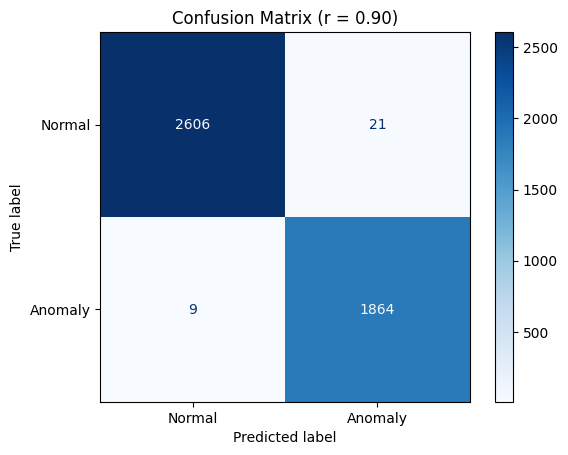

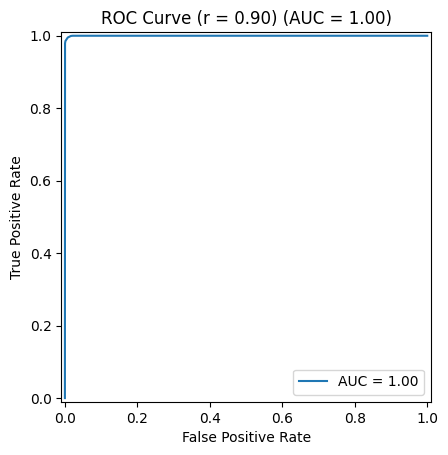

⏱️ Tổng thời gian: 133.09 giây


In [2]:
import numpy as np
import pywt
from scipy.signal import iirnotch, medfilt, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import time
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# 1. Đọc file .ts
def load_ts_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    data_started = False
    data, labels = [], []
    for line in lines:
        line = line.strip()
        if line == "" or line.startswith("@"):
            if line.lower().startswith("@data"):
                data_started = True
            continue
        if data_started:
            parts = line.split(":")
            series = [float(x) for x in parts[0].split(",")]
            label = int(parts[1])
            data.append(series)
            labels.append(label)
    return np.array(data), np.array(labels)

# 2. Hàm tiền xử lý
def apply_notch_filter(x, f0=50.0, Q=30.0, fs=1000):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

def apply_median_filter(x, kernel_size=3):
    return medfilt(x, kernel_size=kernel_size)

def wavelet_denoise(x, wavelet='db4', level=4, threshold=0.05):
    coeffs = pywt.wavedec(x, wavelet, level=level)
    coeffs_thresh = [coeffs[0]]
    for detail in coeffs[1:]:
        coeffs_thresh.append(pywt.threshold(detail, threshold, mode='soft'))
    return pywt.waverec(coeffs_thresh, wavelet)[:len(x)]

def remove_baseline(x):
    return x - np.mean(x)

def compute_mse_psnr(x_orig, x_clean):
    mse = np.mean((x_orig - x_clean)**2)
    mse = max(mse, 1e-10)
    psnr = 20 * np.log10(np.max(x_orig) / np.sqrt(mse))
    return mse, psnr

def process_until_pass(xi, mse_thresh=0.03, psnr_thresh=30):
    while True:
        x1 = apply_notch_filter(xi)
        x2 = apply_median_filter(x1)
        x3 = wavelet_denoise(x2)
        x4 = remove_baseline(x3)
        mse, psnr = compute_mse_psnr(xi, x4)
        if mse < mse_thresh and psnr > psnr_thresh:
            return x4
        else:
            xi = x4

def preprocess_and_filter_all(X, y, mse_thresh=0.03, psnr_thresh=30):
    X_processed, y_processed = [], []
    for xi, yi in zip(X, y):
        x_clean = process_until_pass(xi, mse_thresh, psnr_thresh)
        X_processed.append(x_clean)
        y_processed.append(yi)
    return np.array(X_processed), np.array(y_processed)

# 3. Toeplitz toàn cục
def construct_toeplitz(X):
    n, s = X.shape
    T = np.zeros((2 * n - 1, s + 2))
    for i in range(n):
        mu = np.mean(X[i])
        sigma = np.std(X[i])
        kernel = np.array([mu - 2 * sigma, mu, mu + 2 * sigma])
        for j in range(s):
            row_slice = slice(i, i + n)
            col_slice = slice(j, j + 3)
            if row_slice.stop <= 2 * n - 1 and col_slice.stop <= s + 2:
                T[row_slice, col_slice] += X[i, j] * kernel
    return T

def construct_c(T, n, s):
    C = np.zeros((n, s))
    for i in range(n):
        for j in range(s):
            C[i, j] = np.sum(T[i:i+n, j:j+3])
    return C

# 4. Vẽ confusion + AUC
def plot_confusion_and_auc(y_true, y_pred, y_score, title_suffix=""):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"]).plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.grid(False)
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f"ROC Curve {title_suffix} (AUC = {roc_auc:.2f})")
    plt.show()

# 5. Huấn luyện KNN
def train_and_evaluate_knn(X, y, r=0.9):
    for attempt in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r, stratify=y, random_state=42 + attempt)
        if len(np.unique(y_test)) == 2:
            break
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

    print(classification_report(y_test, y_pred, digits=3))
    plot_confusion_and_auc(y_test, y_pred, y_prob, title_suffix=f"(r = {r:.2f})")

# 6. Pipeline chính
start_pipeline = time.time()
X_train_raw, y_train_raw = load_ts_file("data/ECG5000_TRAIN.ts")
X_test_raw, y_test_raw = load_ts_file("data/ECG5000_TEST.ts")
y_train = np.where(y_train_raw == 1, 0, 1)
y_test = np.where(y_test_raw == 1, 0, 1)
X_all = np.concatenate([X_train_raw, X_test_raw])
y_all = np.concatenate([y_train, y_test])
X_filtered, y_filtered = preprocess_and_filter_all(X_all, y_all)
print("Filtered:", X_filtered.shape)

# 7. Toeplitz local
T = construct_toeplitz(X_filtered)
C = construct_c(T, X_filtered.shape[0], X_filtered.shape[1])

# 8. Spark pooling phân tán
spark = SparkSession.builder.appName("DistributedPooling").getOrCreate()
df = pd.DataFrame({"C_row": C.tolist()})
spark_df = spark.createDataFrame(df)

@udf(ArrayType(DoubleType()))
def pooling_udf(row):
    row = np.array(row)
    return (0.5 * (row[:-1:2] + row[1::2])).tolist()

pooled_df = spark_df.withColumn("pooled", pooling_udf("C_row"))
pooled_list = pooled_df.select("pooled").rdd.map(lambda row: row["pooled"]).collect()
X_feat = np.stack(pooled_list)

# 9. Huấn luyện và đánh giá
train_and_evaluate_knn(X_feat, y_filtered)

print(f"⏱️ Tổng thời gian: {time.time() - start_pipeline:.2f} giây")